In [159]:
import os
import glob
import pylab as pl
import pandas as pd
import seaborn as sns
import numpy as np

In [93]:
import analyze2p.plotting as pplot
import analyze2p.utils as hutils
import analyze2p.aggregate_datasets as aggr

import analyze2p.gratings.utils as gutils

from analyze2p.arousal import dlc_utils as dlcutils
import analyze2p.arousal.with_neural as arous

import analyze2p.decoding as dec

In [63]:
import importlib

In [64]:
%matplotlib notebook

In [79]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

In [80]:
# Set colors
visual_areas, area_colors = pplot.set_threecolor_palette()
dpi = pplot.set_plot_params()
pl.rcParams['axes.labelsize']

7.0

# Select datasets

In [81]:
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'

experiment = 'gratings'
response_type='dff'
responsive_test='ROC'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=500
print(responsive_test, responsive_thr)

#### Responsive params
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters) 
#                             n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

ROC 0.05
traces001|fit-dff_responsive-ROC-thr0.05_boot-500


In [28]:
#### Output dir
base_dir = os.path.join(aggregate_dir, 'decoding', 'py3_arousal')
dst_dir = os.path.join(base_dir, '%s_%s' % (experiment, responsive_test))
if not os.path.exists(dst_dir):
    print("creating output dir:  %s" % dst_dir)
    os.makedirs(dst_dir)

creating output dir:  /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_arousal/gratings_ROC


In [15]:
#### Get metadata for experiment type
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
metad = sdata[sdata.experiment.isin([experiment])].copy()

all_dkeys = [(va, dk) for (va, dk), g in metad.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


,animalid,session,fovnum
visual_area,,,
Li,15,15,15
Lm,9,9,9
V1,9,9,9


#### Load DLC data

In [17]:
#### Check how many datasets missing for DLC
face_src_dir='/n/coxfs01/julianarhee/face-tracking'
dlc_project='facetracking-jyr-2020-01-25'
eyetracker_dir = '/n/coxfs01/2p-data/eyetracker_tmp'

dlc_dsets, missing_dlc = dlcutils.check_missing_dlc(metad)    
print("Need %i datasets analyzed:" % (len(missing_dlc)))
for m in missing_dlc:
    print('    %s' % m)

Checking for existing results: /n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis
25 of 30 datasets with DLC.
Need 5 datasets analyzed:
    20190314_JC070_fov1
    20190315_JC070_fov2
    20190319_JC067_fov1
    20190321_JC070_fov2
    20190306_JC061_fov2


In [18]:
# Pupil -------------------------------------------
pupil_feature='pupil_fraction'
pupil_epoch='stimulus'
pupil_snapshot=391800
redo_pupil=False
pupil_framerate=20.
# -------------------------------------------------
alignment_type='trial'
iti_pre=1.0
iti_post=1.0

In [19]:
print("[%s] ITI pre/post: %.2f/%.2f sec\nEpoch: %s, Alignment: %s" \
      % (experiment, iti_pre, iti_post, pupil_epoch, alignment_type))
# Aggregate dataframes
aggr_pupilmetrics, aggr_params, missing_ = dlcutils.aggregate_dataframes(experiment, 
                            trial_epoch=pupil_epoch, alignment_type=alignment_type,
                            in_rate=pupil_framerate, out_rate=pupil_framerate,
                            iti_pre=iti_pre, iti_post=iti_post, return_missing=True,
                            create_new=False, realign=False, recombine=False,
                            exclude_old=True)
something_missing = [i for v in [v for k, v in missing_.items()] for i in v]

print("Missing %i datasets:" % len(something_missing))
missing_

[gratings] ITI pre/post: 1.00/1.00 sec
Epoch: stimulus, Alignment: trial
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~
Re-aggregating
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
    (gratings) Excluding 20190314_JC070_fov1
    (gratings) Excluding 20190315_JC070_fov2
    (gratings) Excluding 20190319_JC067_fov1
    (gratings) Excluding 20190321_JC070_fov2
    (gratings) Excluding 20190522_JC089_fov1
    (gratings) Excluding 20190612_JC099_fov1
    (gratings) Excluding 20190306_JC061_fov2
    (gratings) Excluding 20190517_JC083_fov1
    (gratings) Excluding 20190627_JC091_fov1
Missing 0 datasets:


{'metrics': array([], dtype=float64), 'traces': array([], dtype=float64)}

#### Load neural data

In [23]:
NDATA0 = aggr.load_responsive_neuraldata(experiment, meta=metad, traceid=traceid,
                    response_type=response_type, trial_epoch=pupil_epoch,
                    responsive_test=responsive_test, responsive_thr=responsive_thr)
cells0 = aggr.get_all_responsive_cells(cells0, NDATA0)
# input data
NDATA = aggr.get_neuraldata_for_included_cells(cells0, NDATA0)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs


In [26]:
check_ = pd.DataFrame([(dk, len(par['missing_trials'])) \
                       for dk, par in aggr_params.items()], columns=['datakey', 'n_missing_trials'])
check_

,datakey,n_missing_trials
0,20190527_JC092_fov3,0
1,20190602_JC091_fov1,1043
2,20190606_JC091_fov1,951
3,20190607_JC091_fov1,549
4,20190609_JC099_fov1,60
5,20190614_JC091_fov1,49
6,20190617_JC099_fov1,2
7,20191018_JC113_fov1,0
8,20191111_JC120_fov1,7
9,20190512_JC083_fov1,179


# Test 1 fov

In [57]:
# Example dir
if not os.path.exists(os.path.join(dst_dir, 'examples')):
    os.makedirs(os.path.join(dst_dir, 'examples'))
    
arousal_colors={'high': 'm', 'low': 'c', 'neither': [0.7]*3}

In [132]:
va='V1'
dk='20191006_JC110_fov1'

nmetrics = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
pmetrics = aggr_pupilmetrics[dk].copy()
sdf = aggr.get_stimuli(dk, experiment, match_names=True)
sdf_float = aggr.get_stimuli(dk, experiment, match_names=False)
sdf_float

,direction,luminance,stimtype,xpos,ypos,aspect,ori,position,speed,sf,size
config001,0,None,gratings,30.0,0.0,1,0,"(30, 0)",10,0.1,20.0
config002,0,None,gratings,30.0,0.0,1,0,"(30, 0)",20,0.1,20.0
config003,0,None,gratings,30.0,0.0,1,0,"(30, 0)",10,0.1,200.0
config004,0,None,gratings,30.0,0.0,1,0,"(30, 0)",20,0.1,200.0
config005,0,None,gratings,30.0,0.0,1,0,"(30, 0)",10,0.5,20.0
...,...,...,...,...,...,...,...,...,...,...,...
config060,0,None,gratings,30.0,0.0,1,315,"(30, 0)",20,0.1,200.0
config061,0,None,gratings,30.0,0.0,1,315,"(30, 0)",10,0.5,20.0
config062,0,None,gratings,30.0,0.0,1,315,"(30, 0)",20,0.5,20.0
config063,0,None,gratings,30.0,0.0,1,315,"(30, 0)",10,0.5,200.0


In [31]:
# Split trials by arousal, only keep neuraldata that has matched trials
splitneural, splitpupil = arous.split_by_arousal(nmetrics, pmetrics, 
                                feature_name='pupil_fraction',
                                n_cuts=3, match_cond_name='config')
# splitpupi

In [56]:
# Add arousal state to original *unsplit* pupil metrics dataframe for plotting
pmetrics['arousal'] = 'neither'
pmetrics.loc[splitpupil[splitpupil.arousal=='low'].index, 'arousal'] = 'low'
pmetrics.loc[splitpupil[splitpupil.arousal=='high'].index, 'arousal'] = 'high'
pmetrics['arousal'].unique()

array(['high', 'neither', 'low'], dtype=object)

In [87]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

<IPython.core.display.Javascript object>


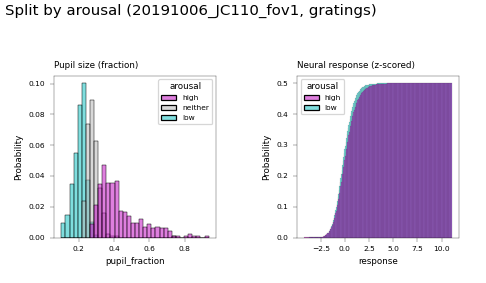

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_arousal/gratings_ROC examples splitdata__gratings_20191006_JC110_fov1


In [88]:
%matplotlib notebook
fig, axn = pl.subplots(1,2,figsize=(6,3.5))
ax=axn[0]; ax.set_title('Pupil size (fraction)', loc='left', fontsize=7);
sns.histplot(pmetrics, x='pupil_fraction', hue='arousal', ax=ax,
            stat='probability', palette=arousal_colors)
ax=axn[1]; ax.set_title('Neural response (z-scored)', loc='left', fontsize=7);
sns.histplot(splitneural, x='response', hue='arousal', ax=ax,
            stat='probability', palette=arousal_colors, cumulative=True)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)
fig.text(0.01, 0.95, 'Split by arousal (%s, %s)' % (dk, experiment), fontsize=12)
pplot.set_panel_aspect(fig)

figname = 'splitdata__%s_%s' % (experiment, dk)
pl.savefig(os.path.join(dst_dir, 'examples', '%s.svg' % figname))
print(dst_dir, 'examples', figname)

# Test decoding 1 FOV`

In [138]:
C_value=1
test_split=0.2
cv_nfolds=3
n_iterations = 1
n_processes=1

class_name = 'ori'
class_values = sdf[class_name].unique()
variation_name=None #'size'
variation_values=None #sdf_float[variation_name].unique()

in_args={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True,
            }

In [139]:
sdf

,direction,luminance,stimtype,xpos,ypos,aspect,ori,position,speed,sf,size
config001,0,None,gratings,30.0,0.0,1,0,"(30, 0)",low,low,low
config002,0,None,gratings,30.0,0.0,1,0,"(30, 0)",high,low,low
config003,0,None,gratings,30.0,0.0,1,0,"(30, 0)",low,low,high
config004,0,None,gratings,30.0,0.0,1,0,"(30, 0)",high,low,high
config005,0,None,gratings,30.0,0.0,1,0,"(30, 0)",low,high,low
...,...,...,...,...,...,...,...,...,...,...,...
config060,0,None,gratings,30.0,0.0,1,315,"(30, 0)",high,low,high
config061,0,None,gratings,30.0,0.0,1,315,"(30, 0)",low,high,low
config062,0,None,gratings,30.0,0.0,1,315,"(30, 0)",high,high,low
config063,0,None,gratings,30.0,0.0,1,315,"(30, 0)",low,high,high


In [140]:
# train_configs = sdf[sdf[class_name].isin(class_values)].index.tolist()
# train_configs

In [141]:
ndf_x = splitneural[splitneural.arousal=='high'].copy()
ndf = aggr.stacked_neuraldf_to_unstacked(ndf_x)
ndf.shape

(446, 90)

In [154]:
chance_performance = 1/8.

In [176]:
iter_num=2
# curr_data = ndf_z.copy()
#res = dec.decode_from_fov(dk, experiment, nmetrics, sdf, verbose=True, **in_args)
#res = dec.select_test(iter_num, None, ndf_z, sdf, False, verbose=True, **in_args)
#res = dec.do_fit_within_fov(iter_num, ndf, sdf, verbose=True, **in_args)
#idf_ = dec.fit_svm(zdata, targets, **clf_params)
#res
r_=[]

for curr_arousal in ['low', 'high']:
    ndf_x = splitneural[splitneural.arousal==curr_arousal].copy()
    ndf = aggr.stacked_neuraldf_to_unstacked(ndf_x)
    for iter_num in np.arange(0, 100):
        res = dec.train_test_gratings_single(iter_num, ndf, sdf_float, **in_args)
        #res = dec.do_fit_within_fov(iter_num, ndf, sdf, verbose=True, **in_args)
        res['arousal'] = curr_arousal
        r_.append(res)

In [177]:
results = pd.concat(r_, axis=0)
results.shape

(3200, 15)

In [184]:
train_transforms = results['train_transform'].unique()
lowsf = [k for k in train_transforms if k.startswith('0.1_')]
highsf = [k for k in train_transforms if k.startswith('0.5_')]

In [186]:
results['stimulus'] = None
results.loc[results['train_transform'].isin(lowsf), 'stimulus'] = 'low_sf'
results.loc[results['train_transform'].isin(highsf), 'stimulus'] = 'high_sf'


In [187]:
results_m = results.groupby(['condition', 'arousal', 'iteration', 'stimulus'])\
                   .mean().reset_index()

<IPython.core.display.Javascript object>


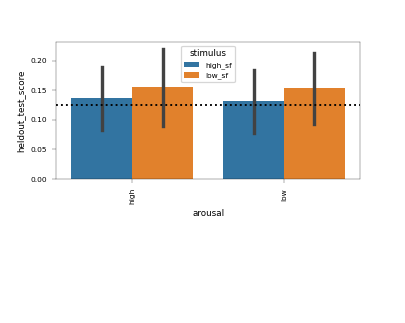

[Text(0, 0, 'high'), Text(1, 0, 'low')]

In [189]:
%matplotlib notebook 
fig, ax = pl.subplots()
sns.barplot(x='arousal', y='heldout_test_score', hue='stimulus', 
            data=results_m, ax=ax, ci='sd')
ax.axhline(y=chance_performance, color='k', linestyle=':')
pl.subplots_adjust(bottom=0.5, right=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

<IPython.core.display.Javascript object>


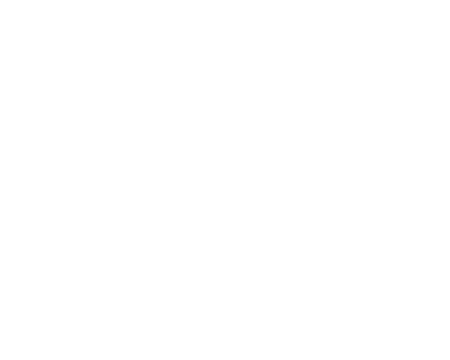

ValueError: Could not interpret input 'train_transform'

In [169]:
# %matplotlib notebook 
# fig, ax = pl.subplots()
# sns.barplot(x='train_transform', y='heldout_test_score', hue='condition', 
#             data=results, ax=ax, ci='sd')
# ax.axhline(y=chance_performance, color='k', linestyle=':')
# pl.subplots_adjust(bottom=0.5, right=0.8)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)